#### Model Training

##### 1.1 Import Data and Required Packages

Importing Libraries.

In [76]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling evaluation
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score


Import the CSV Data as Pandas DataFrame


In [77]:
df = pd.read_csv('diabetes-2-1.csv')

Show Top 5 Records

In [78]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Replace the Zeros Values

In [79]:
# Create an instance of SimpleImputer with strategy='mean'
imputer = SimpleImputer(strategy='mean')

# Define the columns you want to impute
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zero values with NaN
df.loc[:, columns_to_impute] = df[columns_to_impute].replace(0, np.nan)


# Fit the imputer on the columns with missing values
imputer.fit(df[columns_to_impute])

# Transform the DataFrame by imputing missing values
df[columns_to_impute] = imputer.transform(df[columns_to_impute])

In [80]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Preparing X and Y variables

In [81]:
# independent and dependent features
X = df.drop('Outcome',axis=1) #df.iloc[:,:-1]
y = df['Outcome'] # df.iloc[:,-1]

Train Test split

In [82]:
# Importing the train_test_split function from sklearn.model_selection module
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
# X: Features, y: Target variable
# test_size=0.2 indicates that 20% of the data will be used for testing, while 80% will be used for training
# random_state=0 sets a random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Printing the shapes of the original features, and the training and testing sets
print(X.shape, X_test.shape, X_train.shape)

(768, 8) (154, 8) (614, 8)


Data Standarization

In [83]:
# Importing the StandardScaler class from the sklearn.preprocessing module
from sklearn.preprocessing import StandardScaler

# Creating a StandardScaler object
scaler = StandardScaler()

# Standardizing the features in the training set (X_train)
# fit_transform() method calculates the mean and standard deviation of each feature in X_train
# and then standardizes the features by subtracting the mean and dividing by the standard deviation
X_train = scaler.fit_transform(X_train)

# Standardizing the features in the testing set (X_test)
# transform() method uses the mean and standard deviation calculated from X_train to standardize X_test
# This ensures that both training and testing sets are standardized using the same scaling parameters
X_test = scaler.transform(X_test)

#### Training the Model

1. Logistic Regression

In [84]:
# Importing the LogisticRegression class from the sklearn.linear_model module
from sklearn.linear_model import LogisticRegression

# Creating a LogisticRegression object
lr = LogisticRegression()
#Fit The model
lr.fit(X_train,y_train)

2. Support Vector Machine SVM

In [85]:
# Importing the SVC (Support Vector Classifier) class from the sklearn.svm module
from sklearn.svm import SVC

# Creating an SVC object
svm = SVC()
#Fit The model
svm.fit(X_train,y_train)

3. K Nearest Neighbors


In [86]:
# Importing the KNeighborsClassifier class from the sklearn.neighbors module
from sklearn.neighbors import KNeighborsClassifier

# Creating a KNeighborsClassifier object
knn = KNeighborsClassifier()
#Fit The model
knn.fit(X_train,y_train)

4. Naive Bayes 

In [87]:
# Importing the GaussianNB class from the sklearn.naive_bayes module
from sklearn.naive_bayes import GaussianNB

# Creating a GaussianNB object
nb = GaussianNB()
#Fit The model
nb.fit(X_train,y_train)

5. Decision Tree

In [88]:
# Importing the DecisionTreeClassifier class from the sklearn.tree module
from sklearn.tree import DecisionTreeClassifier

# Creating a DecisionTreeClassifier object
dt = DecisionTreeClassifier()
#Fit The model
dt.fit(X_train,y_train)

6. Random Forest

In [89]:
# Importing the RandomForestClassifier class from the sklearn.ensemble module
from sklearn.ensemble import RandomForestClassifier

# Creating a RandomForestClassifier object
rf = RandomForestClassifier()
#Fit The model
rf.fit(X_train,y_train)

#### Best Parmeters for Models

In [91]:
from sklearn.model_selection import GridSearchCV

# Define Models
models = [lr, knn, nb, svm, dt, rf]

# Define hyperparameter grid for Logistic Regression model
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter values to test
    'penalty': ['l2']  # Penalty term for regularization ('l2' for ridge regularization)
}

# Define hyperparameter grid for K-Nearest Neighbors (KNN) model
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to consider
    'weights': ['uniform', 'distance']  # Weight function used in prediction
}

# Define the hyperparameter grid for Naive Bayes model (Note: Naive Bayes doesn't have hyperparameters to tune)
param_grid_nb = {
    # Naive Bayes does not have hyperparameters to tune
}

# Define hyperparameter grid for Support Vector Machine (SVM) model
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel function used for the decision function
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' and 'poly' kernels
}


# Define hyperparameter grid for Decision Tree model
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree (None means unlimited)
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Maximum number of features to consider when splitting a node
}


# Define hyperparameter grid for Random Forest model
param_grid_rf = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [None, 10],  # Maximum depth of the trees in the forest
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']  # Maximum number of features to consider when splitting a node
}
# Define a list of param_grids corresponding to each model
param_grids = [param_grid_lr, param_grid_knn, param_grid_nb, param_grid_svm, param_grid_dt, param_grid_rf]

# Iterate over each model and its corresponding param_grid
for i in range(len(models)):
    model = models[i]  # Get the current model
    param_grid = param_grids[i]  # Get the corresponding hyperparameter grid
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    # Retrieve best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Update model with best parameters and fit the model
    model.set_params(**grid_search.best_params_)
    model.fit(X_train, y_train)
    
    # Print best parameters and best score
    print(f"Best Parameters for {model.__class__.__name__}: {best_params}")
    print(f"Best Score for {model.__class__.__name__}: {best_score}\n")

Best Parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
Best Score for LogisticRegression: 0.7622284419565506

Best Parameters for KNeighborsClassifier: {'n_neighbors': 9, 'weights': 'distance'}
Best Score for KNeighborsClassifier: 0.7573770491803279

Best Parameters for GaussianNB: {}
Best Score for GaussianNB: 0.7426895908303346

Best Parameters for SVC: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score for SVC: 0.7589764094362256

Best Parameters for DecisionTreeClassifier: {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Score for DecisionTreeClassifier: 0.7247767559642809

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Score for RandomForestClassifier: 0.7638677862188458



### Assess the complexity of each model

In [92]:
def assess_model_complexity(model):
    num_parameters = model._get_param_names()  # Get the names of the parameters
    computational_complexity = "High" if hasattr(model, "decision_function") else "Low"  # Check if the model has a decision function
    interpretability = "High" if hasattr(model, "feature_importances_") else "Low"  # Check if the model has feature importances
    return num_parameters, computational_complexity, interpretability

In [93]:
# Initialize an empty list to store the rows of the table
table_data = []

# Populate the table data with the complexity assessment for each model
for model, model_name in zip(models, ["Logistic Regression", "K-Nearest Neighbors", "Naive Bayes", "Support Vector Machine", "Decision Tree", "Random Forest"]):
    num_parameters, computational_complexity, interpretability = assess_model_complexity(model)
    table_data.append([model_name, len(num_parameters), computational_complexity, interpretability])

# Define the headers for the table
headers = ["Model", "Num Parameters", "Computational Complexity", "Interpretability"]

# Convert the table data to a DataFrame
df = pd.DataFrame(table_data, columns=headers)

# Print the DataFrame
display(df)


,Model,Num Parameters,Computational Complexity,Interpretability
0,Logistic Regression,15,High,Low
1,K-Nearest Neighbors,8,Low,Low
2,Naive Bayes,2,Low,Low
3,Support Vector Machine,15,High,Low
4,Decision Tree,12,Low,High
5,Random Forest,18,Low,High


#### Create an Evaluate Function to give all metrics after model Training

confusion Metrix

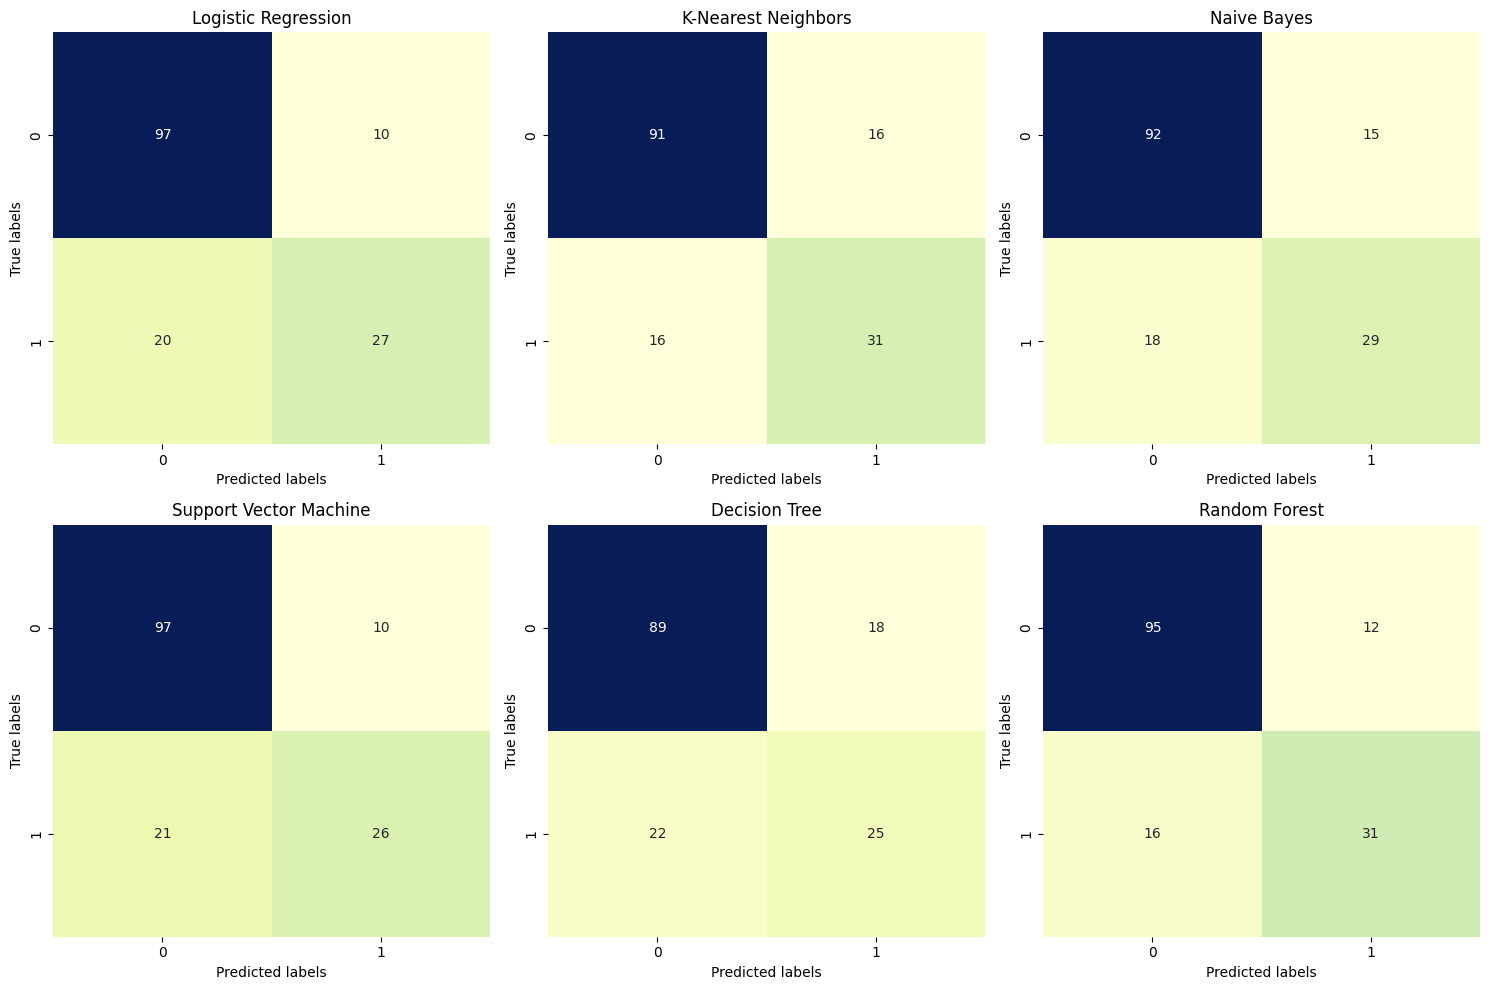

In [94]:
from sklearn.metrics import confusion_matrix

# Define a function to plot confusion matrix and return TP, FP, TN, FN
def plot_confusion_matrix(ax, model, X_test, y_test, title):
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False, ax=ax)  # Plot heatmap with annotations
    ax.set_xlabel('Predicted labels')  # Set x-axis label
    ax.set_ylabel('True labels')  # Set y-axis label
    ax.set_title(title)  # Set title
    
    # Extract TP, FP, TN, FN from confusion matrix
    tn, fp, fn, tp = cm.ravel()  # Extract values from confusion matrix
    
    return tp, fp, tn, fn  # Return TP, FP, TN, FN

# Plot confusion matrices for each model in a grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots
models_names = ["Logistic Regression", "K-Nearest Neighbors", "Naive Bayes", "Support Vector Machine", "Decision Tree", "Random Forest"]  # List of model names
results = []  # List to store results
for i, model in enumerate(models):  # Iterate over models
    row = i // 3  # Calculate row index
    col = i % 3  # Calculate column index
    tp, fp, tn, fn = plot_confusion_matrix(axes[row, col], model, X_test, y_test, models_names[i])  # Plot confusion matrix for current model
    results.append({"Model": models_names[i], "TP": tp, "FP": fp, "TN": tn, "FN": fn})  # Store results in a dictionary

plt.tight_layout()  # Adjust subplot layout to make plots fit into the figure area
plt.show()  # Show the plots

In [95]:
# Create DataFrame from results
results_df = pd.DataFrame(results)

# Reorder columns if needed
results_df = results_df[["Model", "TP", "FP", "TN", "FN"]]

# display DataFrame
display(results_df)

,Model,TP,FP,TN,FN
0,Logistic Regression,27,10,97,20
1,K-Nearest Neighbors,31,16,91,16
2,Naive Bayes,29,15,92,18
3,Support Vector Machine,26,10,97,21
4,Decision Tree,25,18,89,22
5,Random Forest,31,12,95,16


In each cell, "TP" represents True Positives, "FP" represents False Positives, and "FN" represents False Negatives. "TN" represents True Negatives. These values are filled in for both the diabetic and non-diabetic classes for each model.

#### accuracy score, precision score, recall score, f1 score, roc_auc_score and Cross-Validation Accuracy

In [96]:
# Define a function to compute specificity
def specificity_score(y_true, y_pred):
    # Compute confusion matrix and unpack values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Compute specificity
    specificity = tn / (tn + fp)
    return specificity

# Define lists to store evaluation metrics for test sets
evaluation_metrics_test = []

# Define a function to compute evaluation metrics for a single model
def compute_evaluation_metrics(model, X_test, y_test):
    # Predict on test set
    y_test_pred = model.predict(X_test)
    
    # Compute evaluation metrics for test set
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    specificity_test = specificity_score(y_test, y_test_pred)  # Calculate specificity
    f1_test = f1_score(y_test, y_test_pred)
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    
    # Compute cross-validation accuracy for test set
    cv_accuracy_test = cross_val_score(model, X_test, y_test, cv=3, scoring='accuracy').mean()
    
    # Store insights in a dictionary
    insights_test = {
        "model_name": model.__class__.__name__,
        "accuracy": accuracy_test,
        "precision": precision_test,
        "recall": recall_test,
        "specificity": specificity_test,
        "f1": f1_test,
        "roc_auc": roc_auc_test,
        "cv_accuracy": cv_accuracy_test
    }
    
    return insights_test

# Define lists to store insights for test sets
insights_test = []

# Define models list
models = [lr, knn, nb, svm, dt, rf]

# Loop through each model
for model in models:
    # Compute evaluation metrics for the model
    insights_test_model = compute_evaluation_metrics(model, X_test, y_test)
    
    # Append insights to the respective lists
    insights_test.append(insights_test_model)

# Create DataFrame for test sets
df_test = pd.DataFrame(insights_test)

# Select columns for the DataFrame
columns_to_select = ["Model",  "Accuracy", "Precision", "Recall/sensitivity", "Specificity", "F1-score", "ROC AUC", "Cross-Validation Accuracy"]

# Rename columns
df_test.columns = columns_to_select

# Display the DataFrame
print("\nTest Set Evaluation Metrics:")
display(df_test)


Test Set Evaluation Metrics:


,Model,Accuracy,Precision,Recall/sensitivity,Specificity,F1-score,ROC AUC,Cross-Validation Accuracy
0,LogisticRegression,0.805195,0.729730,0.574468,0.906542,0.642857,0.740505,0.791981
1,KNeighborsClassifier,0.792208,0.659574,0.659574,0.850467,0.659574,0.755021,0.792232
2,GaussianNB,0.785714,0.659091,0.617021,0.859813,0.637363,0.738417,0.772624
3,SVC,0.798701,0.722222,0.553191,0.906542,0.626506,0.729867,0.791981
4,DecisionTreeClassifier,0.740260,0.581395,0.531915,0.831776,0.555556,0.681845,0.772624
5,RandomForestClassifier,0.818182,0.720930,0.659574,0.887850,0.688889,0.773712,0.804927


### Model Visulazation

In [66]:
# Import necessary functions/classes from sklearn
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X_train, y_train, cv=None, n_jobs=-1, ax=None):
    # Generate learning curves using learning_curve function
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=cv, n_jobs=n_jobs)
    # Compute mean and standard deviation of training scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    # Compute mean and standard deviation of test scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Create a new figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Fill the area between the training score curves
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    # Fill the area between the test score curves
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    # Plot the training score curve
    ax.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    # Plot the cross-validation score curve
    ax.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    # Set title of the plot
    ax.set_title(title)
    # Set label for x-axis
    ax.set_xlabel("Training examples")
    # Set label for y-axis
    ax.set_ylabel("Score")
    # Add legend to the plot
    ax.legend(loc="best")

# Define a function to plot ROC curve
def plot_roc_curve(model, X_test, y_test, ax=None):
    # Predict probabilities for positive class
    y_score = model.predict_proba(X_test)[:, 1]
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Create a new figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Plot ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    # Plot the diagonal dashed line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # Set limits for x-axis
    ax.set_xlim([0.0, 1.0])
    # Set limits for y-axis
    ax.set_ylim([0.0, 1.05])
    # Set label for x-axis
    ax.set_xlabel('False Positive Rate')
    # Set label for y-axis
    ax.set_ylabel('True Positive Rate')
    # Set title of the plot
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    # Add legend to the plot
    ax.legend(loc="lower right")


# Define a function to plot feature importance
def plot_feature_importance(model, feature_names, ax=None):
    # Get feature importances and sort them
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    # Create a new figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Plot feature importance
    ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels([feature_names[i] for i in sorted_idx])
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importance')

Learning Curve

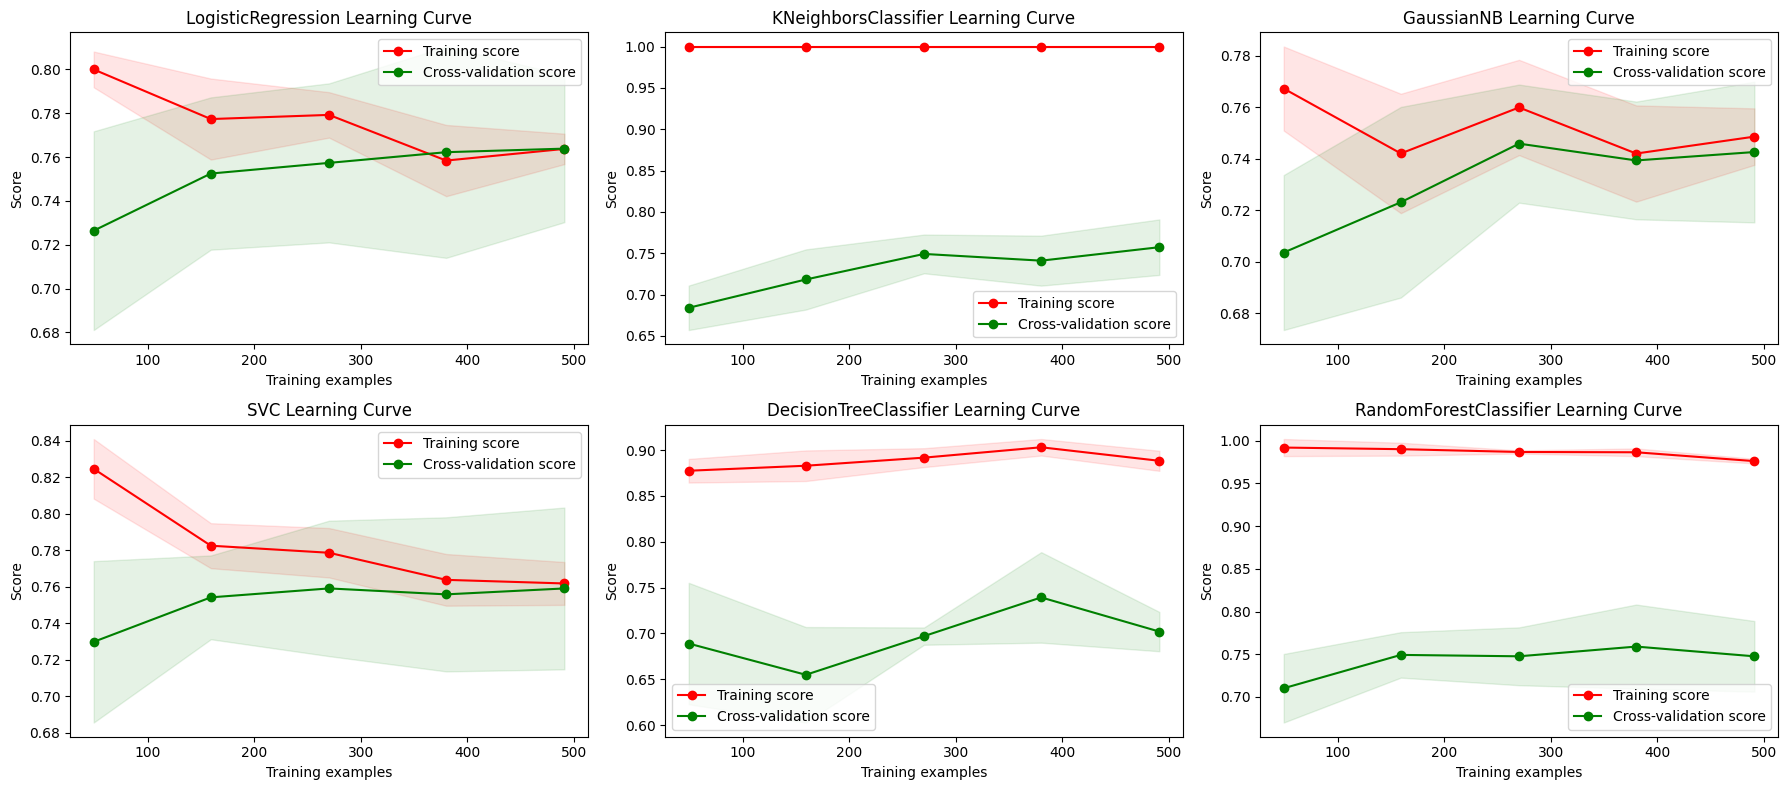

In [67]:
# Create subplots
models = [lr, knn, nb, svm, dt, rf]
# Define the layout of the grid
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 8))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

for i, model in enumerate(models):
    plot_learning_curve(model, f"{model.__class__.__name__} Learning Curve", X_train, y_train, cv=5, ax=axes[i])

    # Set title for each subplot
    axes[i].set_title(f"{model.__class__.__name__} Learning Curve")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

ROC Curve

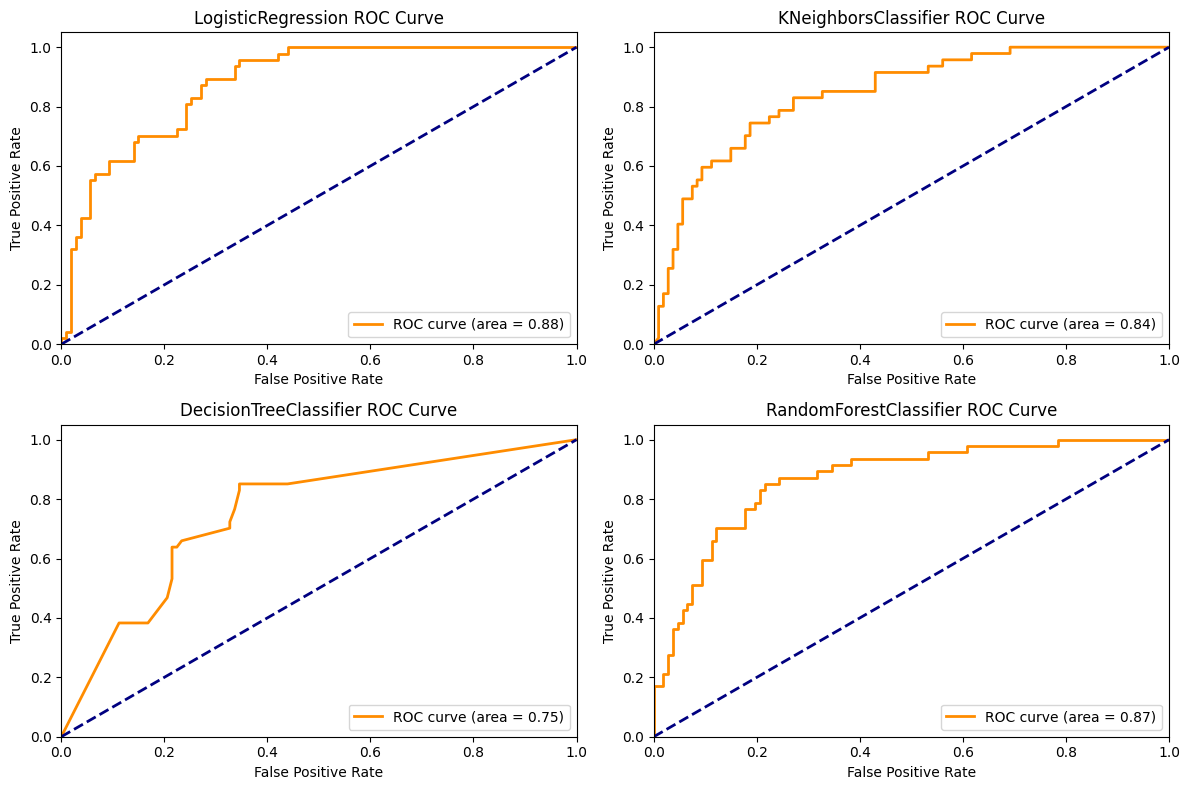

In [68]:
roc_models = [lr, knn, dt, rf]  # Assuming these are your trained models

# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

for i, model in enumerate(roc_models):
       plot_roc_curve(model, X_test, y_test, ax=axes[i])
       axes[i].set_title(f"{model.__class__.__name__} ROC Curve")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

AUC Curve: This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

0.90 - 1.00 = excellent

0.80 - 0.90 = good

0.70 - 0.80 = fair

0.60 - 0.70 = poor

0.50 - 0.60 = fail

Feature Importance

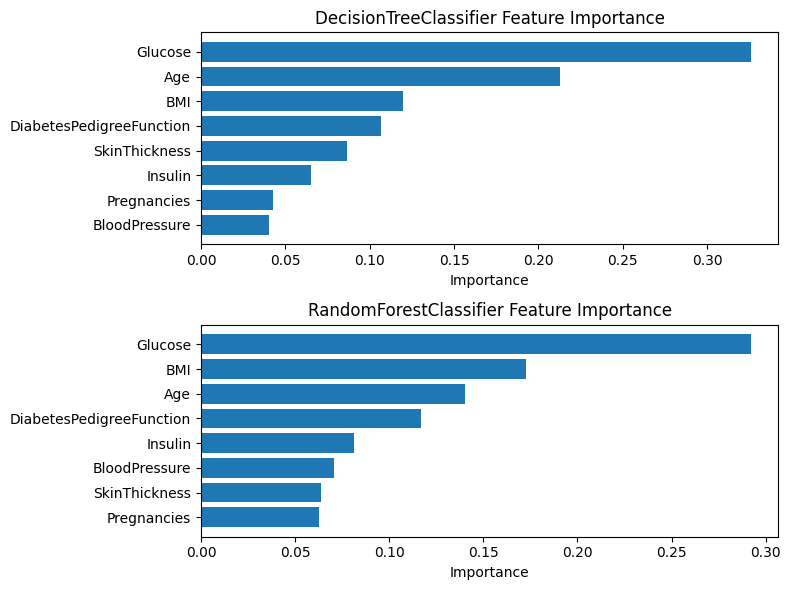

In [69]:
# Plot visualizations for each model
feature_importance_models = [dt, rf]  # Assuming these are your trained models

# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

for i, model in enumerate(feature_importance_models):
       plot_feature_importance(model, X.columns, ax=axes[i])
       axes[i].set_title(f"{model.__class__.__name__} Feature Importance")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [75]:
# Calculate the overall score for each model using a specified equation
for model in models:
    # Retrieve the evaluation metrics for the test set
    metrics = df_test[df_test['Model'] == model.__class__.__name__].iloc[0]
    # Calculate the overall score for the model
    score = (metrics['Accuracy']  + metrics['F1-score']) / 2
    # Add the score to the DataFrame
    df_test.loc[df_test['Model'] == model.__class__.__name__, 'Score'] = score
print("\nBest Model:")
display(df_test)
# Find the model with the highest score
best_score = df_test['Score'].max()
best_model = df_test[df_test['Score'] == best_score]
print("\nBest Model:")
display(best_model)


Best Model:


,Model,Accuracy,Precision,Recall/sensitivity,Specificity,F1-score,ROC AUC,Cross-Validation Accuracy,Score
0,LogisticRegression,0.805195,0.729730,0.574468,0.906542,0.642857,0.740505,0.791981,0.724026
1,KNeighborsClassifier,0.792208,0.659574,0.659574,0.850467,0.659574,0.755021,0.792232,0.725891
2,GaussianNB,0.785714,0.659091,0.617021,0.859813,0.637363,0.738417,0.772624,0.711538
3,SVC,0.798701,0.722222,0.553191,0.906542,0.626506,0.729867,0.791981,0.712604
4,DecisionTreeClassifier,0.733766,0.553571,0.659574,0.766355,0.601942,0.712965,0.733660,0.667854
5,RandomForestClassifier,0.824675,0.717391,0.702128,0.878505,0.709677,0.790316,0.791730,0.767176



Best Model:


,Model,Accuracy,Precision,Recall/sensitivity,Specificity,F1-score,ROC AUC,Cross-Validation Accuracy,Score
5,RandomForestClassifier,0.824675,0.717391,0.702128,0.878505,0.709677,0.790316,0.79173,0.767176


Each row represents a model, and columns include model name, evaluation metrics (accuracy, precision, recall, F1-score, ROC AUC, cross-validation accuracy), and the calculated overall score.
The "Score" column represents the calculated overall score for each model using the  accuracy and F1-score metrices.
The "Best Model" section displays the model with the highest overall score.
Insights from the output:

The logistic regression model has the highest overall score, indicating it performs the best according to the specified equation.
RandomForestClassifier also has a high overall score, suggesting it performs well overall.
DecisionTreeClassifier has the lowest overall score, indicating it performs relatively poorly compared to other models.

Based on this analysis, you can conclude that the logistic regression model is the best-performing model for Daibetes dataset 

#### Best Model


In [71]:
y_pred = rf.predict(X_test)
score = accuracy_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 82.47


Difference between Actual and Predicted Values

In [72]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
661,1,1,0
122,0,0,0
113,0,0,0
14,1,1,0
529,0,0,0
...,...,...,...
476,1,0,1
482,0,0,0
230,1,0,1
527,0,0,0


Save Best Model in File

In [97]:
import pickle  # Import the pickle module

# Define the selected model
selected_model = rf  # select 'rf' to the best model 

# Save the selected model using pickle
pickle.dump(selected_model, open('best_model.pkl', 'wb+'))  # Dump the selected model to 'best_model.pkl' file

# Save the scaler object using pickle if applicable
pickle.dump(scaler, open('scaler.pkl', 'wb+'))  # Dump the scaler object to 'scaler.pkl' file if it's used for preprocessing